# Navigating between various vertical coordinates in the ocean

In oceanography it is often required to transform the vertical coordinate system of data. The large scale circulation for example, follows surfaces of constant density rather than constant depth levels, thus certain analyses require a coordinate transformation.

The general process of vertical coordinates transformation as discussed here, consists of two steps: *Regridding* and *remapping*.

**Regridding**: The process of definining the target depth coordinates (e.g. the depth defined by certain density levels or e.g. just a different depth spacing)

**Remapping**: Converting a data profile from the source depth profile to the target depth profile.

There are several methods to perform both regridding and remapping implemented in `xarrayutils.vertical_coordinates`. In the following we will see how to implement different combinations of method for both processes. For general applications the conservative `conservative_remap` function is recommended for remapping, due to the property of conserving total tracer mass (see examples below).

> At the moment these functions require very explicit input (dimension names etc), which will be simplified with a wrapper function in the future.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Dont forget to install
conda install gcsfs zarr fsspec
for the docs

We are going to investigate the coordinate transformations using data from an indealized high resolution model run produced by [Dhruv Balwada](https://dhruvbalwada.github.io)(to read more about the data see [his paper](https://dhruvbalwada.github.io/assets/documents/Balwada_et_al2018.pdf)).

In [2]:
import fsspec
ds = xr.open_zarr(fsspec.get_mapper('gcs://pangeo-data/balwada/channel_ridge_resolutions/20km/tracer_10day_snap'), consolidated=True)
ds = ds.isel(time=slice(0, 20))
# ds.to_zarr('offline_backup.zarr')
# ds = xr.open_zarr('offline_backup.zarr')

## Adjusting the vertical coordinate orientation
All the following steps crucially assume that the **depth values are increasing with the depth dimension**. The values can be negative but then have progress towards less negative values as you follow the logical depth index. 
This dataset has negative depth values that decrease. The simplest fix is to flip the sign of all depth values.

In [3]:
for dim in ['Z', 'Zp1', 'Zl', 'Zu']:
    ds.coords[dim] = -ds[dim]

ds.Z

<xarray.DataArray 'Z' (Z: 76)>
array([5.000000e-01, 1.570000e+00, 2.790000e+00, 4.185000e+00, 5.780000e+00,
       7.595000e+00, 9.660000e+00, 1.201000e+01, 1.468000e+01, 1.770500e+01,
       2.112500e+01, 2.499000e+01, 2.934500e+01, 3.424000e+01, 3.972500e+01,
       4.585500e+01, 5.269000e+01, 6.028000e+01, 6.868500e+01, 7.796500e+01,
       8.817500e+01, 9.937000e+01, 1.116000e+02, 1.249150e+02, 1.393650e+02,
       1.549900e+02, 1.718250e+02, 1.899000e+02, 2.092350e+02, 2.298550e+02,
       2.517700e+02, 2.749850e+02, 2.995050e+02, 3.253200e+02, 3.524200e+02,
       3.807900e+02, 4.104100e+02, 4.412550e+02, 4.733050e+02, 5.065400e+02,
       5.409350e+02, 5.764650e+02, 6.131100e+02, 6.508550e+02, 6.896850e+02,
       7.295950e+02, 7.705850e+02, 8.126600e+02, 8.558350e+02, 9.001350e+02,
       9.455950e+02, 9.922600e+02, 1.040180e+03, 1.089425e+03, 1.140080e+03,
       1.192235e+03, 1.246005e+03, 1.301520e+03, 1.358920e+03, 1.418375e+03,
       1.480075e+03, 1.544225e+03, 1.611060e+03, 1.680845e+03, 1.753875e+03,
       1.830475e+03, 1.911015e+03, 1.995905e+03, 2.085595e+03, 2.180595e+03,
       2.281470e+03, 2.388845e+03, 2.503415e+03, 2.625955e+03, 2.757325e+03,
       2.912665e+03], dtype=float32)
Coordinates:
    PHrefC   (Z) float32 dask.array<chunksize=(38,), meta=np.ndarray>
  * Z        (Z) float32 0.5 1.57 2.79 4.185 ... 2625.955 2757.325 2912.665
    drF      (Z) float32 dask.array<chunksize=(38,), meta=np.ndarray>

Another issue with this dataset is that in the surface, the profile is sometimes unstable (density does not strictly increase with depth). This will cause issues when interpolating, and thus for now we use a time mean of the dataset between ~200-1500m depth.

In [4]:
# check monotonicity for all profiles
ds = ds.mean('time')
ds = ds.isel(YC=slice(10,-10), Z=slice(28,60), Zp1=slice(28,61))
# since we operate on the depth dimension we convert it to a single chunk to avoid doing this all the time later
ds = ds.chunk({'Z':-1})

assert (ds.T.diff('Z') < 0).all(['Z']).all()

## Transforming to a different (spatially uniform) depth coordinate system
In this case we will transform the dataset to different depth coordinates (we leave out the `regridding` step and manually provide a new depth grid). This example might be useful when you want to convert different depth grids (e.g. from several observational products) into a uniform grid.

### Using linear interpolation as remapping
For the simplest case (using linear interpolation for both the regridding and remapping), xarray offers all the necessary tools built in.

In [5]:
# define a new depth array
z_new = np.arange(10,2000, 20)

ds_z_new = ds.interp(Z=z_new)
ds_z_new.Z

<xarray.DataArray 'Z' (Z: 100)>
array([  10,   30,   50,   70,   90,  110,  130,  150,  170,  190,  210,  230,
        250,  270,  290,  310,  330,  350,  370,  390,  410,  430,  450,  470,
        490,  510,  530,  550,  570,  590,  610,  630,  650,  670,  690,  710,
        730,  750,  770,  790,  810,  830,  850,  870,  890,  910,  930,  950,
        970,  990, 1010, 1030, 1050, 1070, 1090, 1110, 1130, 1150, 1170, 1190,
       1210, 1230, 1250, 1270, 1290, 1310, 1330, 1350, 1370, 1390, 1410, 1430,
       1450, 1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650, 1670,
       1690, 1710, 1730, 1750, 1770, 1790, 1810, 1830, 1850, 1870, 1890, 1910,
       1930, 1950, 1970, 1990])
Coordinates:
    PHrefC   (Z) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    drF      (Z) float32 dask.array<chunksize=(100,), meta=np.ndarray>
  * Z        (Z) int64 10 30 50 70 90 110 130 ... 1890 1910 1930 1950 1970 1990

The depth coordinate `Z` is now regularly spaced instead of the surface refined resolution of the original dataset, we 'remapped' all data onto a new vertical grid using linear interpolation. Lets compare the actual data.

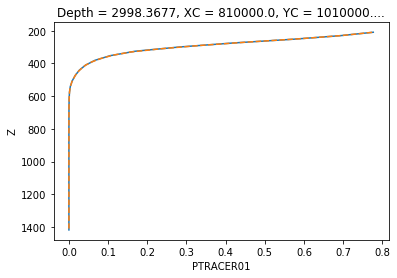

In [6]:
ds.PTRACER01.isel(XC=40, YC=40).plot(y='Z', yincrease=False)
ds_z_new.PTRACER01.isel(XC=40, YC=40).plot(ls='--', y='Z', yincrease=False)

Visually that looks pretty good and these results might be sufficient for certain applications. The biggest downside of this approach is that the total amount of tracer is not conserved.

In [7]:
dz_original =  ds.drF #vertical cell thickness of the model grid
tracer_intz_original = (ds.PTRACER01 * dz_original).sum('Z')
dz_new = 20 #This is easy to infer since the grid is uniformly spaced
tracer_intz_new = (ds_z_new.PTRACER01 * dz_new).sum('Z')

print(tracer_intz_original.isel(XC=40, YC=40).load())
print(tracer_intz_new.isel(XC=40, YC=40).load())

<xarray.DataArray ()>
array(72.79866, dtype=float32)
Coordinates:
    Depth    float32 2998.3677
    XC       float32 810000.0
    YC       float32 1010000.0
    rA       float32 400000000.0
<xarray.DataArray 'PTRACER01' ()>
array(72.659355, dtype=float32)
Coordinates:
    Depth    float32 2998.3677
    XC       float32 810000.0
    YC       float32 1010000.0
    rA       float32 400000000.0


The difference might seem small but for certain applications (e.g. budget reconstruction), this is not acceptable.


However,  we can do better by using the `conservative_remap` function:

### Using conservative remapping
For this method we need not only the cell centers, but instead need to provide the depths of the vertical bounding surfaces.

In [8]:
from xarrayutils.vertical_coordinates import conservative_remap

# the conservative remapping needs information about the upper and lower bounds of the source and target cells.
bounds_original = ds.Zp1 # depth position of vertical bounding surface
bounds_new = xr.DataArray(np.arange(0,2020, 20), dims=['new_bounds'])

# now we can remap the tracer data again (at the moment the depth dimensions have to be explicitly defined).
ds_z_cons_new = conservative_remap(ds.PTRACER01,bounds_original, bounds_new,
                                   z_dim='Z', z_bnd_dim='Zp1', z_bnd_dim_target='new_bounds', mask=True) # the associated depth dimensions for each array
# replace the new depth dimension values with the appropriate depth 
ds_z_cons_new.coords['remapped'] = xr.DataArray(z_new, coords=[('remapped', z_new)])

/Users/juliusbusecke/miniconda/envs/test_env_xarrayutils/lib/python3.6/site-packages/xarray/core/computation.py:1188: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])


In [9]:
ds_z_cons_new

<xarray.DataArray (YC: 80, XC: 100, remapped: 100)>
dask.array<where, shape=(80, 100, 100), dtype=float64, chunksize=(80, 100, 100)>
Coordinates:
    Depth     (YC, XC) float32 dask.array<chunksize=(80, 100), meta=np.ndarray>
  * XC        (XC) float32 10000.0 30000.0 50000.0 ... 1970000.0 1990000.0
  * YC        (YC) float32 210000.0 230000.0 250000.0 ... 1770000.0 1790000.0
    rA        (YC, XC) float32 dask.array<chunksize=(80, 100), meta=np.ndarray>
  * remapped  (remapped) int64 10 30 50 70 90 110 ... 1910 1930 1950 1970 1990

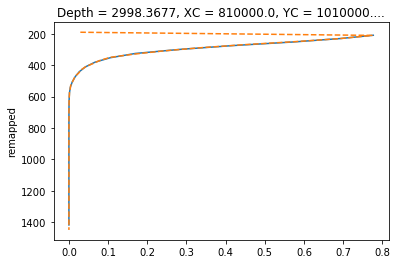

In [10]:
ds.PTRACER01.isel(XC=40, YC=40).plot(y='Z', yincrease=False)
ds_z_cons_new.isel(XC=40, YC=40).plot(ls='--', y='remapped', yincrease=False)

`conservative_remap` takes into account *every* overlap between source and target cells. See for instance the uppermost value of `ds_z_cons_new`, the low value is due to the fact that there is a traceramount in the upper half of the first source cell, which is then distributed over the much larger targer cell. This ensures that the full tracer amount is conserved to floating point precision.

In [11]:
tracer_intz_cons_new = (ds_z_cons_new * dz_new).sum('remapped')
np.isclose(tracer_intz_original.isel(XC=40, YC=40).load(), tracer_intz_cons_new.isel(XC=40, YC=40).load())

True

This is in fact true for every grid position:

In [12]:
np.isclose(tracer_intz_original, tracer_intz_cons_new).all()

True

Ok this is nice, but it really gets interesting when we define our new depth coordinates 

## Switching to potential temperature coordinates using only linear interpolation

### Regridding using linear interpolation
The xarray internals can only help us if we want to interpolate on values of a dimension (1D), e.g. if we want to know the temperature as a function of a new depth. For the case of temperature coordinates, we aim to do the opposite: Find the depth for a given temperature value. This is not possible with xarray at the moment, but can be achieved using `linear_interpolation_regrid`.
> The values used to find the new cell depths have to be monotonic! Currently there is no check implemented for this but non-monotonic fields can lead to undesired behaviour. See above for how to check for monotonicity.



In [13]:
from xarrayutils.vertical_coordinates import linear_interpolation_regrid

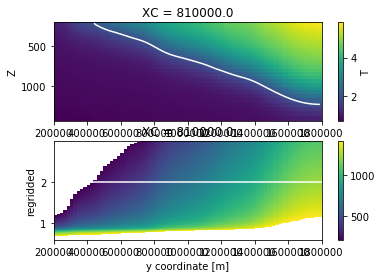

In [14]:
t_vals = np.arange(0.6,3, 0.01)
temperature_values = xr.DataArray(t_vals, coords=[('t', t_vals)]) # define the new temperature grid

z_temp_coord = linear_interpolation_regrid(ds.Z, ds.T, temperature_values, target_value_dim='t') 

plt.subplot(2,1,1)
ds.T.isel(XC=40).plot(x='YC', yincrease=False)
ds.T.isel(XC=40).plot.contour(levels=[2], colors='w',x='YC', yincrease=False)
plt.subplot(2,1,2)
z_temp_coord.isel(XC=40).plot(x='YC')
plt.axhline(2, color='w')

As you can see in this example, the line of constant temperature is moving deeper with increasing y, and that is reflected in the depth values along a constant depth coordinate in the regridded values. Now we can remap other data values on the corresponding depths. The simplest method is again linear interpolation:

### Using linear interpolation as remapping

In [15]:
from xarrayutils.vertical_coordinates import linear_interpolation_remap

In [16]:
# we cant have nans, so just fill them with an out of bounds value
# z_temp_coord = z_temp_coord.fillna(1e8) # this should be fixed now?

ds_temp_linear = linear_interpolation_remap(ds.Z, ds.T, z_temp_coord)
# this requires me to downgrade dask, should be solved soon (see here https://github.com/pydata/xarray/pull/3660)
ds_temp_linear

<xarray.DataArray (YC: 80, XC: 100, remapped: 240)>
dask.array<<numpy.vectorize object at 0x1203dc630>, shape=(80, 100, 240), dtype=float32, chunksize=(80, 100, 240)>
Coordinates:
    Depth     (YC, XC) float32 dask.array<chunksize=(80, 100), meta=np.ndarray>
  * XC        (XC) float32 10000.0 30000.0 50000.0 ... 1970000.0 1990000.0
  * YC        (YC) float32 210000.0 230000.0 250000.0 ... 1770000.0 1790000.0
    rA        (YC, XC) float32 dask.array<chunksize=(80, 100), meta=np.ndarray>
  * remapped  (remapped) float64 0.6 0.61 0.62 0.63 0.64 ... 2.96 2.97 2.98 2.99

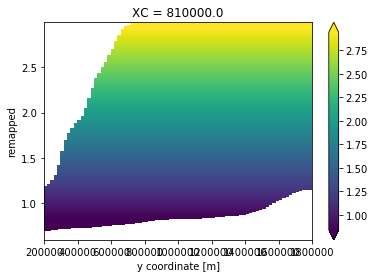

In [17]:
ds_temp_linear.isel(XC=40).plot(x='YC', robust=True)

As expected, when we remap the temperature field itself, we get a matching horizontal stratification. Now lets do something more interesting and look at the tracer field on a constant temperature surface of 2 deg:

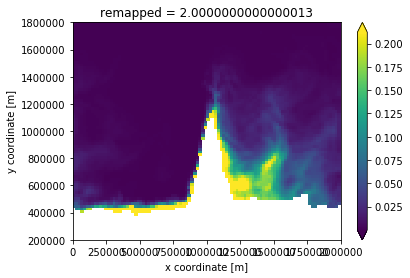

In [18]:
ds_temp_linear = linear_interpolation_remap(ds.Z, ds.PTRACER01, z_temp_coord)
ds_temp_linear.sel(remapped=2, method='nearest').plot(robust=True)

Pretty neat, but again there is no guarantee that the total tracer content is preserved with linear interpolation, but with a few modifications we can implement the conservative remapping here as well.

### Using conservative remapping

In [19]:
# we need to capture all the tracer cells, so if we dont specify our temperature range covering the Tracer min and max, the total tracer amount will not be conserved.
t_vals = np.hstack([ds.T.min().load().data[np.newaxis], np.arange(0.6,3, 0.01), ds.T.max().load().data[np.newaxis]])
t_vals
# for now the results are ordered by the bin values. Since the temperature is decreasing, we need to flip the logical axis.
# We could also do that after the regridding, but this seems more elegant.
t_vals = np.flip(t_vals)

temperature_values = xr.DataArray(t_vals, coords=[('t', t_vals)]) # define the new temperature grid
temperature_values

# # additionally to covering the full range of `ds.T`, we need to provide the bounds of `z` to the function.
z_temp_bounds = linear_interpolation_regrid(ds.Z, ds.T, temperature_values, z_bounds=ds.Zp1 ,target_value_dim='t', z_bounds_dim='Zp1')
z_temp_bounds.isel(XC=40, YC=40).load()

<xarray.DataArray (regridded: 242)>
array([ 199.25   ,  490.79758,  492.66046,  494.52335,  496.38626,
        498.24915,  500.11203,  501.9749 ,  503.83783,  505.7007 ,
        507.52982,  509.33118,  511.13257,  512.93396,  514.7353 ,
        516.5367 ,  518.3381 ,  520.1394 ,  521.9408 ,  523.7422 ,
        525.5435 ,  527.3449 ,  529.1463 ,  530.9477 ,  532.749  ,
        534.5504 ,  536.3518 ,  538.15314,  539.9545 ,  541.7473 ,
        543.52985,  545.3123 ,  547.09485,  548.8774 ,  550.65985,
        552.4424 ,  554.2249 ,  556.00745,  557.7899 ,  559.57245,
        561.355  ,  563.13745,  564.92   ,  566.7025 ,  568.485  ,
        570.2675 ,  572.05005,  573.8325 ,  575.61505,  577.4062 ,
        579.2052 ,  581.0043 ,  582.8033 ,  584.6023 ,  586.4013 ,
        588.2003 ,  589.9994 ,  591.7984 ,  593.5974 ,  595.3964 ,
        597.19543,  598.9945 ,  600.7935 ,  602.5925 ,  604.39154,
        606.19055,  607.9896 ,  609.78864,  611.58765,  613.3962 ,
        615.25714,  617.11804,  618.979  ,  620.8399 ,  622.70087,
        624.5618 ,  626.4227 ,  628.2837 ,  630.1446 ,  632.00555,
        633.86646,  635.7274 ,  637.5883 ,  639.4493 ,  641.31024,
        643.17114,  645.0321 ,  646.893  ,  648.75397,  650.61487,
        652.5749 ,  654.5495 ,  656.5242 ,  658.4988 ,  660.47345,
        662.4481 ,  664.4227 ,  666.3974 ,  668.3721 ,  670.3467 ,
        672.32135,  674.296  ,  676.2706 ,  678.2453 ,  680.22   ,
        682.1946 ,  684.16925,  686.1439 ,  688.1185 ,  690.1303 ,
        692.28436,  694.4385 ,  696.5925 ,  698.7466 ,  700.9007 ,
        703.05475,  705.20886,  707.3629 ,  709.517  ,  711.6711 ,
        713.8252 ,  715.97925,  718.13336,  720.2874 ,  722.4415 ,
        724.5956 ,  726.7497 ,  728.90375,  731.23584,  733.652  ,
        736.0682 ,  738.4844 ,  740.9005 ,  743.3167 ,  745.73285,
        748.14905,  750.56525,  752.9814 ,  755.3976 ,  757.8138 ,
        760.2299 ,  762.6461 ,  765.06226,  767.47845,  769.89465,
        772.5761 ,  775.3638 ,  778.15137,  780.93896,  783.7266 ,
        786.5142 ,  789.3019 ,  792.0895 ,  794.87714,  797.66473,
        800.45233,  803.24   ,  806.0276 ,  808.81525,  811.60284,
        814.72095,  818.0409 ,  821.36084,  824.68085,  828.0008 ,
        831.32074,  834.6407 ,  837.9607 ,  841.28064,  844.6006 ,
        847.92053,  851.24054,  854.5605 ,  858.3554 ,  862.4462 ,
        866.5371 ,  870.6279 ,  874.7188 ,  878.8097 ,  882.9005 ,
        886.9914 ,  891.0823 ,  895.1731 ,  899.264  ,  904.2431 ,
        909.4625 ,  914.682  ,  919.9014 ,  925.12085,  930.3403 ,
        935.55975,  940.7792 ,  946.12854,  953.02783,  959.9272 ,
        966.8265 ,  973.72577,  980.6251 ,  987.5244 ,  995.2211 ,
       1004.6629 , 1014.10474, 1023.5466 , 1032.9884 , 1043.3538 ,
       1056.6708 , 1069.9878 , 1083.3048 , 1099.7661 , 1118.9015 ,
       1138.0369 , 1164.511  , 1191.8623 , 1228.8461 , 1270.1136 ,
       1315.4075 , 1361.5223 , 1403.8291 , 1448.64   , 1448.64   ,
       1448.64   , 1448.64   , 1448.64   , 1448.64   , 1448.64   ,
       1448.64   , 1448.64   , 1448.64   , 1448.64   , 1448.64   ,
       1448.64   , 1448.64   , 1448.64   , 1448.64   , 1448.64   ,
       1448.64   , 1448.64   , 1448.64   , 1448.64   , 1448.64   ,
       1448.64   , 1448.64   ], dtype=float32)
Coordinates:
    Depth      float32 2998.3677
    XC         float32 810000.0
    YC         float32 1010000.0
    rA         float32 400000000.0
  * regridded  (regridded) float64 6.056 2.99 2.98 2.97 ... 0.62 0.61 0.6 0.5969

And now we can use these cell bounding values exactly like we did before.

In [20]:
# now we can remap the tracer data again (at the moment the depth dimensions have to be explicitly defined).
ds_temp_cons = conservative_remap(ds.PTRACER01,bounds_original, z_temp_bounds,
                                   z_dim='Z', z_bnd_dim='Zp1', z_bnd_dim_target='regridded', mask=True) # the associated depth dimensions for each array
# # replace the new depth dimension values with the appropriate depth (here the middle of the temperature cell bounds)
t_vals = z_temp_bounds.coords['regridded'].data
t_vals = 0.5 * (t_vals[1:] + t_vals[0:-1])

ds_temp_cons.coords['remapped'] = xr.DataArray(t_vals, coords=[('remapped', t_vals)])

/Users/juliusbusecke/miniconda/envs/test_env_xarrayutils/lib/python3.6/site-packages/xarray/core/computation.py:1188: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])


/Users/juliusbusecke/miniconda/envs/test_env_xarrayutils/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/Users/juliusbusecke/miniconda/envs/test_env_xarrayutils/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


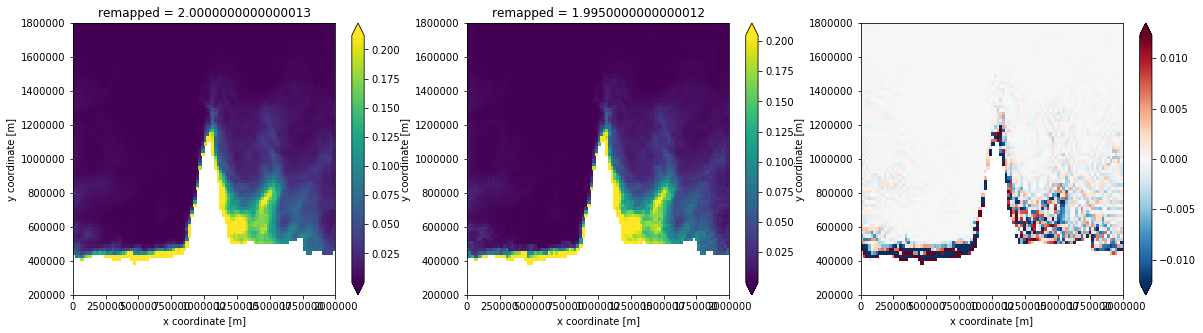

In [21]:
plt.figure(figsize=[20,5])
plt.subplot(1,3,1)
ds_temp_linear.sel(remapped=2, method='nearest').plot(robust=True)
plt.subplot(1,3,2)
ds_temp_cons.sel(remapped=2, method='nearest').plot(robust=True)
plt.subplot(1,3,3)
(ds_temp_cons.sel(remapped=2, method='nearest')-ds_temp_linear.sel(remapped=2, method='nearest')).plot(robust=True)

And most importantly, the vertical tracer content is again conserved:

In [22]:
dz_remapped = z_temp_bounds.diff('regridded').rename({'regridded':'remapped'})
dz_remapped.coords['remapped'] = ds_temp_cons.coords['remapped']

tracer_intz_remapped_temp = (ds_temp_cons*dz_remapped).sum('remapped')

xr.testing.assert_allclose(tracer_intz_original, tracer_intz_remapped_temp)

![](https://media.giphy.com/media/lxcz7ntpCKJfq/giphy.gif)